In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import numpy as np

from utils.plots import visualize_vehicle_trajectories, plot_interactive_matrix, visualize_merge_pairs_grid, visualize_merge_chains_grid, visualize_consolidated_merges_grid
from utils.loader import load_data_from_database
from utils.transformer import categorize_ids, find_merging_pairs, build_merge_chains, apply_merges_to_summary
from data_pipeline import process_all_sessions

In [2]:
print("Do you want to load data from the database? This may take a while.")
if input("Type 'y' to proceed: ").lower() == 'y':
    df = load_data_from_database()
    df = df.sort_values(['date_time', 'frame_id'])
else:
    df = pd.read_csv("raw_traffic_data.csv", parse_dates=['date_time'])
    df = df.sort_values(['date_time', 'frame_id'])

Do you want to load data from the database? This may take a while.


In [3]:
df['session_id'] = (
    (df['frame_id'].diff() < 0)
).cumsum()

In [4]:
df.groupby('session_id').agg('size')

session_id
0       28090
1       15936
2     8238814
3       33537
4        7082
5       10582
6        8504
7       17186
8       30834
9        5361
10      26281
11      17976
12      12914
13      26303
14     489001
15    1178073
dtype: int64

In [5]:
# 1. Select one stable session and sort
session_id_to_analyze = 2
session_df = df[df['session_id'] == session_id_to_analyze].sort_values(['vehicle_id', 'date_time'])


In [6]:
final_summary = categorize_ids(session_df)
final_summary.groupby('category').agg('size')

category
Flickering       589
Ghost         326864
Noise          13949
Partial        31947
Perfect        29378
Static          1430
dtype: int64

In [7]:
final_summary

session_id  vehicle_id  y_start  y_end     w_mean      w_std  w_start  \
0                2           0       79     79  36.000000        NaN     36.0   
1                2           1      139    139  26.000000        NaN     26.0   
2                2           2      156    156  29.000000        NaN     29.0   
3                2           3      266      0  40.458333   4.712854     52.0   
4                2           4      263      0  39.704348   4.643377     49.0   
...            ...         ...      ...    ...        ...        ...      ...   
404152           2      404152        0      0  34.181818   0.873863     35.0   
404153           2      404153        0      0  27.900000   6.552621     24.0   
404154           2      404154        0    260  39.770833  12.581925     23.0   
404155           2      404155      262      0  58.587500   7.838066     47.0   
404156           2      404156        0      0  42.000000        NaN     42.0   

        w_end      h_mean      h_std  ...  frames_count  \
0        36.0  104.000000        NaN  ...             1   
1        26.0   76.000000        NaN  ...             1   
2        29.0   85.000000        NaN  ...             1   
3        34.0   62.750000  18.379568  ...            48   
4        35.0   56.808696  17.317416  ...           115   
...       ...         ...        ...  ...           ...   
404152   32.0   32.363636   1.747726  ...            11   
404153   16.0   55.850000  12.938213  ...            20   
404154   31.0   65.708333  10.803427  ...            96   
404155   40.0   86.387500  35.246148  ...            80   
404156   42.0   35.000000        NaN  ...             1   

                          t_start                      t_end      x_mean  \
0      2025-11-29 18:02:55.716052 2025-11-29 18:02:55.716052   22.000000   
1      2025-11-29 18:02:56.049113 2025-11-29 18:02:56.049113   21.000000   
2      2025-11-29 18:02:56.348841 2025-11-29 18:02:56.348841   15.000000   
3      2025-11-29 18:04:13.894244 2025-11-29 18:04:17.009382  134.895833   
4      2025-11-29 18:04:24.233579 2025-11-29 18:04:31.759723  139.086957   
...                           ...                        ...         ...   
404152 2025-12-18 11:02:21.878373 2025-12-18 11:02:22.248756   23.272727   
404153 2025-12-18 11:02:30.214003 2025-12-18 11:02:30.930256   31.450000   
404154 2025-12-18 11:02:31.062303 2025-12-18 11:02:34.625383   15.895833   
404155 2025-12-18 11:02:44.751133 2025-12-18 11:02:47.868994  132.512500   
404156 2025-12-18 11:02:48.078780 2025-12-18 11:02:48.078780  138.000000   

            x_std  path_completeness      w_cv      h_cv  movement_efficiency  \
0             NaN           0.358621  0.000000  0.000000             0.358621   
1             NaN           0.262069  0.000000  0.000000             0.262069   
2             NaN           0.293103  0.000000  0.000000             0.293103   
3        2.998153           1.000000  0.116487  0.292901             0.020833   
4        2.019924           1.000000  0.116949  0.304837             0.008696   
...           ...                ...       ...       ...                  ...   
404152   0.646670           0.110345  0.025565  0.054003             0.010031   
404153   4.850122           0.231034  0.234861  0.231660             0.011552   
404154  13.094377           1.000000  0.316361  0.164415             0.010417   
404155   3.416245           1.000000  0.133784  0.408001             0.012500   
404156        NaN           0.120690  0.000000  0.000000             0.120690   

        category  
0          Ghost  
1          Ghost  
2          Ghost  
3        Perfect  
4        Perfect  
...          ...  
404152     Ghost  
404153     Ghost  
404154   Perfect  
404155   Perfect  
404156     Ghost  

[404157 rows x 22 columns]

In [8]:
fig = plot_interactive_matrix(final_summary, max_points_per_category=500)
fig.show()


In [9]:
filter_category = 'Static'
filtered_final_summary = final_summary[(final_summary['category'] == filter_category)]
filtered_final_summary

session_id  vehicle_id  y_start  y_end      w_mean      w_std  \
3286             2        3286        0      0  151.522222   7.492608   
3378             2        3378        0     14   91.863636  29.536333   
3437             2        3437       14     12   78.183544  20.867443   
3479             2        3479       29     14   65.243902  17.727140   
3534             2        3534       21     19   53.113208  24.406994   
...            ...         ...      ...    ...         ...        ...   
399337           2      399337       27     28   57.580882  13.846543   
399375           2      399375       27     50   55.369369   8.791450   
399383           2      399383       28     26   62.389831  12.694325   
399553           2      399553       48     17   61.283019  15.229939   
400445           2      400445       34     22   58.702970  10.099054   

        w_start  w_end      h_mean      h_std  ...  frames_count  \
3286      157.0  144.0  232.416667  36.995678  ...           180   
3378       63.0   66.0   43.522727   5.745518  ...            88   
3437       81.0   92.0   50.626582   7.272218  ...           158   
3479       71.0   49.0   48.609756   7.103029  ...           123   
3534       34.0   31.0   40.839623   8.084243  ...           106   
...         ...    ...         ...        ...  ...           ...   
399337     56.0   43.0   47.860294   8.391506  ...           136   
399375     51.0   39.0   47.099099   7.968067  ...           111   
399383     49.0   35.0   45.593220  10.493985  ...           118   
399553     56.0   42.0   45.276730   6.967294  ...           159   
400445     54.0   44.0   46.207921   7.485074  ...           101   

                          t_start                      t_end      x_mean  \
3286   2025-11-29 20:01:13.645452 2025-11-29 20:01:25.832346    0.000000   
3378   2025-11-29 20:02:13.242142 2025-11-29 20:02:18.916754   50.227273   
3437   2025-11-29 20:05:18.333606 2025-11-29 20:05:28.653285  126.588608   
3479   2025-11-29 20:06:27.183160 2025-11-29 20:06:35.233508  133.463415   
3534   2025-11-29 20:08:42.202358 2025-11-29 20:08:49.112807  137.443396   
...                           ...                        ...         ...   
399337 2025-12-18 06:20:59.014487 2025-12-18 06:21:04.248598   39.669118   
399375 2025-12-18 06:22:54.890347 2025-12-18 06:22:59.163649   51.099099   
399383 2025-12-18 06:24:01.362063 2025-12-18 06:24:05.875740   39.805085   
399553 2025-12-18 06:35:51.857683 2025-12-18 06:35:58.026473  137.213836   
400445 2025-12-18 07:28:13.458685 2025-12-18 07:28:17.390072  132.653465   

            x_std  path_completeness      w_cv      h_cv  movement_efficiency  \
3286     0.000000           0.220690  0.049449  0.159178             0.001226   
3378    12.265949           0.117241  0.321524  0.132012             0.001332   
3437    10.481485           0.124138  0.266903  0.143644             0.000786   
3479     8.004397           0.137931  0.271706  0.146124             0.001121   
3534    10.661082           0.124138  0.459528  0.197951             0.001171   
...           ...                ...       ...       ...                  ...   
399337   9.815374           0.168966  0.240471  0.175333             0.001242   
399375   3.453470           0.165517  0.158778  0.169177             0.001491   
399383   5.162750           0.158621  0.203468  0.230165             0.001344   
399553   6.180169           0.162069  0.248518  0.153882             0.001019   
400445   5.210443           0.141379  0.172037  0.161987             0.001400   

        category  
3286      Static  
3378      Static  
3437      Static  
3479      Static  
3534      Static  
...          ...  
399337    Static  
399375    Static  
399383    Static  
399553    Static  
400445    Static  

[1430 rows x 22 columns]

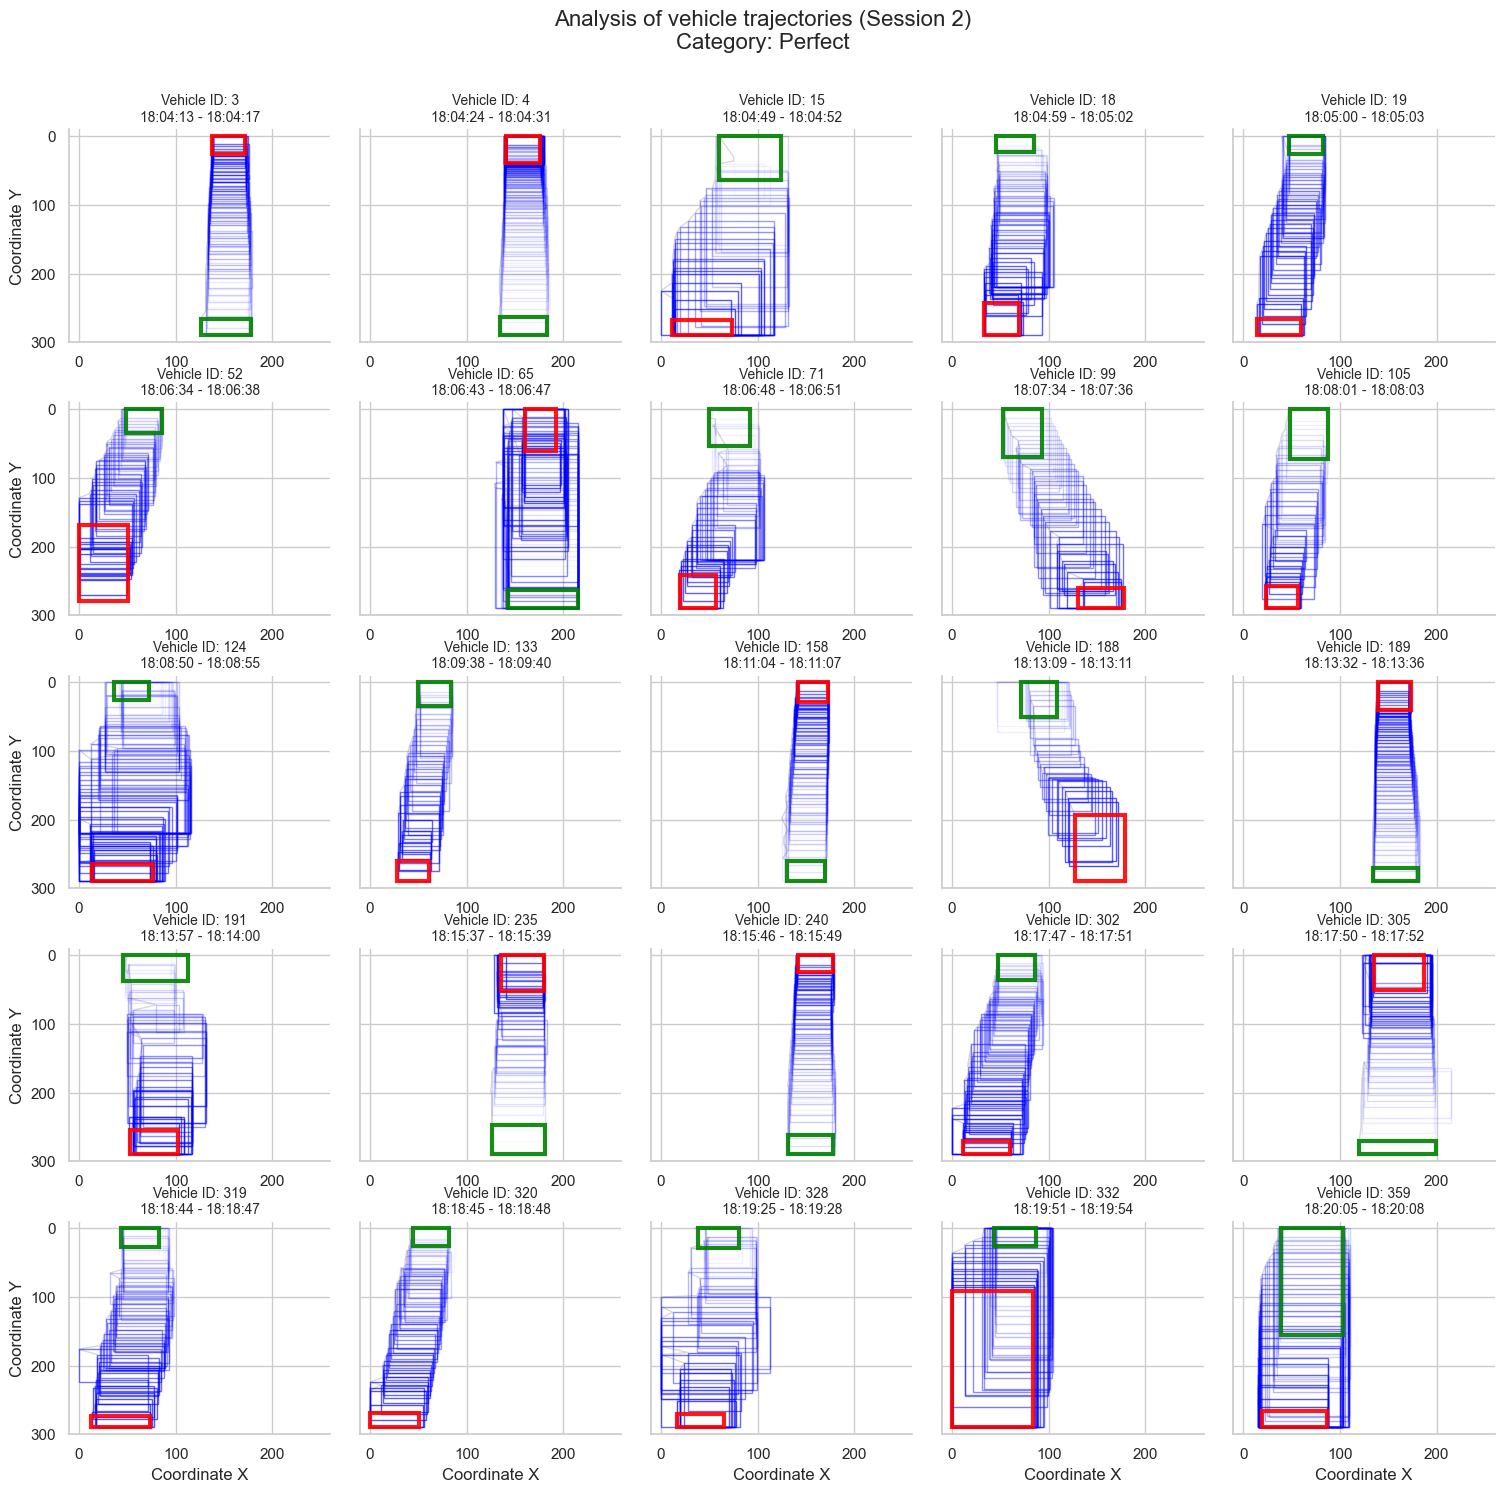

In [20]:
filter_category = 'Perfect'
filtered_final_summary = final_summary[(final_summary['category'] == filter_category)]
ids_to_plot = filtered_final_summary['vehicle_id']
plot_data = session_df[session_df['vehicle_id'].isin(ids_to_plot)]
visualize_vehicle_trajectories(plot_data, session_id=session_id_to_analyze, max_vehicles=25, min_records=20, category=filter_category)

In [11]:
plot_data

id  vehicle_id    area   x    y  width  heigth  \
10102095   44379          20  1308.5  35    0   77.0    22.0   
10102093   44381          20  1407.5  36    0   78.0    24.0   
10102091   44383          20  1573.5  39    0   75.0    28.0   
10102089   44385          20  1200.0  41    0   49.0    26.0   
10102087   44387          20  1513.5  41    0   73.0    30.0   
...          ...         ...     ...  ..  ...    ...     ...   
9792862   353612       21873  6049.5  15  148  109.0   104.0   
9792859   353614       21873  4115.0  15  156   74.0    79.0   
9792858   353616       21873  5206.0  18  158  109.0   107.0   
9792856   353618       21873  5136.5  18  162  111.0   106.0   
9792852   353621       21873  3410.0  16  165   68.0    68.0   

                          date_time  frame_id  session_id  
10102095 2025-11-29 18:05:02.199087      2022           2  
10102093 2025-11-29 18:05:02.268376      2023           2  
10102091 2025-11-29 18:05:02.320416      2024           2  
10102089 2025-11-29 18:05:02.370982      2025           2  
10102087 2025-11-29 18:05:02.429886      2026           2  
...                             ...       ...         ...  
9792862  2025-12-01 07:33:23.598018   3387830           2  
9792859  2025-12-01 07:33:23.636258   3387831           2  
9792858  2025-12-01 07:33:23.672983   3387832           2  
9792856  2025-12-01 07:33:23.709795   3387833           2  
9792852  2025-12-01 07:33:23.751648   3387834           2  

[394 rows x 10 columns]

In [12]:
plot_data.groupby('vehicle_id').agg('size')

vehicle_id
20       46
26       30
29       35
31       64
8324     50
8328     43
21867    96
21873    30
dtype: int64

In [13]:
merge_results = find_merging_pairs(final_summary, category_filter=['Partial', 'Static', 'Noise', 'Ghost'])
print(f"Found pairs for merging: {len(merge_results)}")
merge_results

Found pairs for merging: 115503


old_id  new_id  gap_sec  y_dist  size_diff_pct  transition_w_diff_pct  \
0            1       2     0.30      17           11.5                   11.5   
1            5       6     0.19       0            5.1                    5.1   
2            6       7     0.12       0            3.6                    0.0   
3            7       8     0.13       0            0.4                    2.9   
4            8       9     0.18       0            5.3                    8.6   
...        ...     ...      ...     ...            ...                    ...   
115498  404146  404147     0.07       0           11.0                    0.0   
115499  404147  404148     0.07       0            5.5                    0.0   
115500  404149  404150     0.14       0            0.0                    0.0   
115501  404150  404151     0.08       0            6.1                    6.1   
115502  404151  404152     0.14       0            2.3                    0.0   

        transition_h_diff_pct  old_x_start  old_y_start  old_x_end  ...  \
0                        11.8         21.0          139       21.0  ...   
1                         0.0        139.0            0      139.0  ...   
2                         2.6        141.0            0      141.0  ...   
3                        13.5        141.0            0      141.0  ...   
4                         5.9        141.0            0      141.0  ...   
...                       ...          ...          ...        ...  ...   
115498                    1.8          0.0            0        0.0  ...   
115499                    0.0          0.0            0        0.0  ...   
115500                    0.0         21.0            0       21.0  ...   
115501                    3.7         21.0            0       21.0  ...   
115502                   11.5         21.0            0       21.0  ...   

        new_y_end  new_h_start  new_h_end  new_w_mean  new_w_start  new_w_end  \
0             156         85.0       85.0        29.0         29.0       29.0   
1               0         39.0       39.0        37.0         37.0       37.0   
2               0         38.0       37.0        35.7         37.0       35.0   
3               0         42.0       34.0        35.8         36.0       35.0   
4               0         32.0       34.0        33.9         32.0       32.0   
...           ...          ...        ...         ...          ...        ...   
115498          0         54.0       50.0        23.3         23.0       24.0   
115499          0         50.0       47.0        24.6         24.0       25.0   
115500          0         27.0       27.0        33.0         33.0       33.0   
115501          0         26.0       26.0        35.0         35.0       35.0   
115502          0         29.0       32.0        34.2         35.0       32.0   

                      old_t_start                  old_t_end  \
0      2025-11-29 18:02:56.049113 2025-11-29 18:02:56.049113   
1      2025-11-29 18:04:32.084640 2025-11-29 18:04:32.084640   
2      2025-11-29 18:04:32.279015 2025-11-29 18:04:32.279015   
3      2025-11-29 18:04:32.394433 2025-11-29 18:04:32.681492   
4      2025-11-29 18:04:32.812259 2025-11-29 18:04:33.070943   
...                           ...                        ...   
115498 2025-12-18 11:02:18.244189 2025-12-18 11:02:19.529443   
115499 2025-12-18 11:02:19.597312 2025-12-18 11:02:19.804614   
115500 2025-12-18 11:02:21.524013 2025-12-18 11:02:21.524013   
115501 2025-12-18 11:02:21.663600 2025-12-18 11:02:21.663600   
115502 2025-12-18 11:02:21.741689 2025-12-18 11:02:21.741689   

                      new_t_start                  new_t_end  
0      2025-11-29 18:02:56.348841 2025-11-29 18:02:56.348841  
1      2025-11-29 18:04:32.279015 2025-11-29 18:04:32.279015  
2      2025-11-29 18:04:32.394433 2025-11-29 18:04:32.681492  
3      2025-11-29 18:04:32.812259 2025-11-29 18:04:33.070943  
4      2025-11-29 18:04:33.248983 2025-11-29 18:04:33.902455  
...           

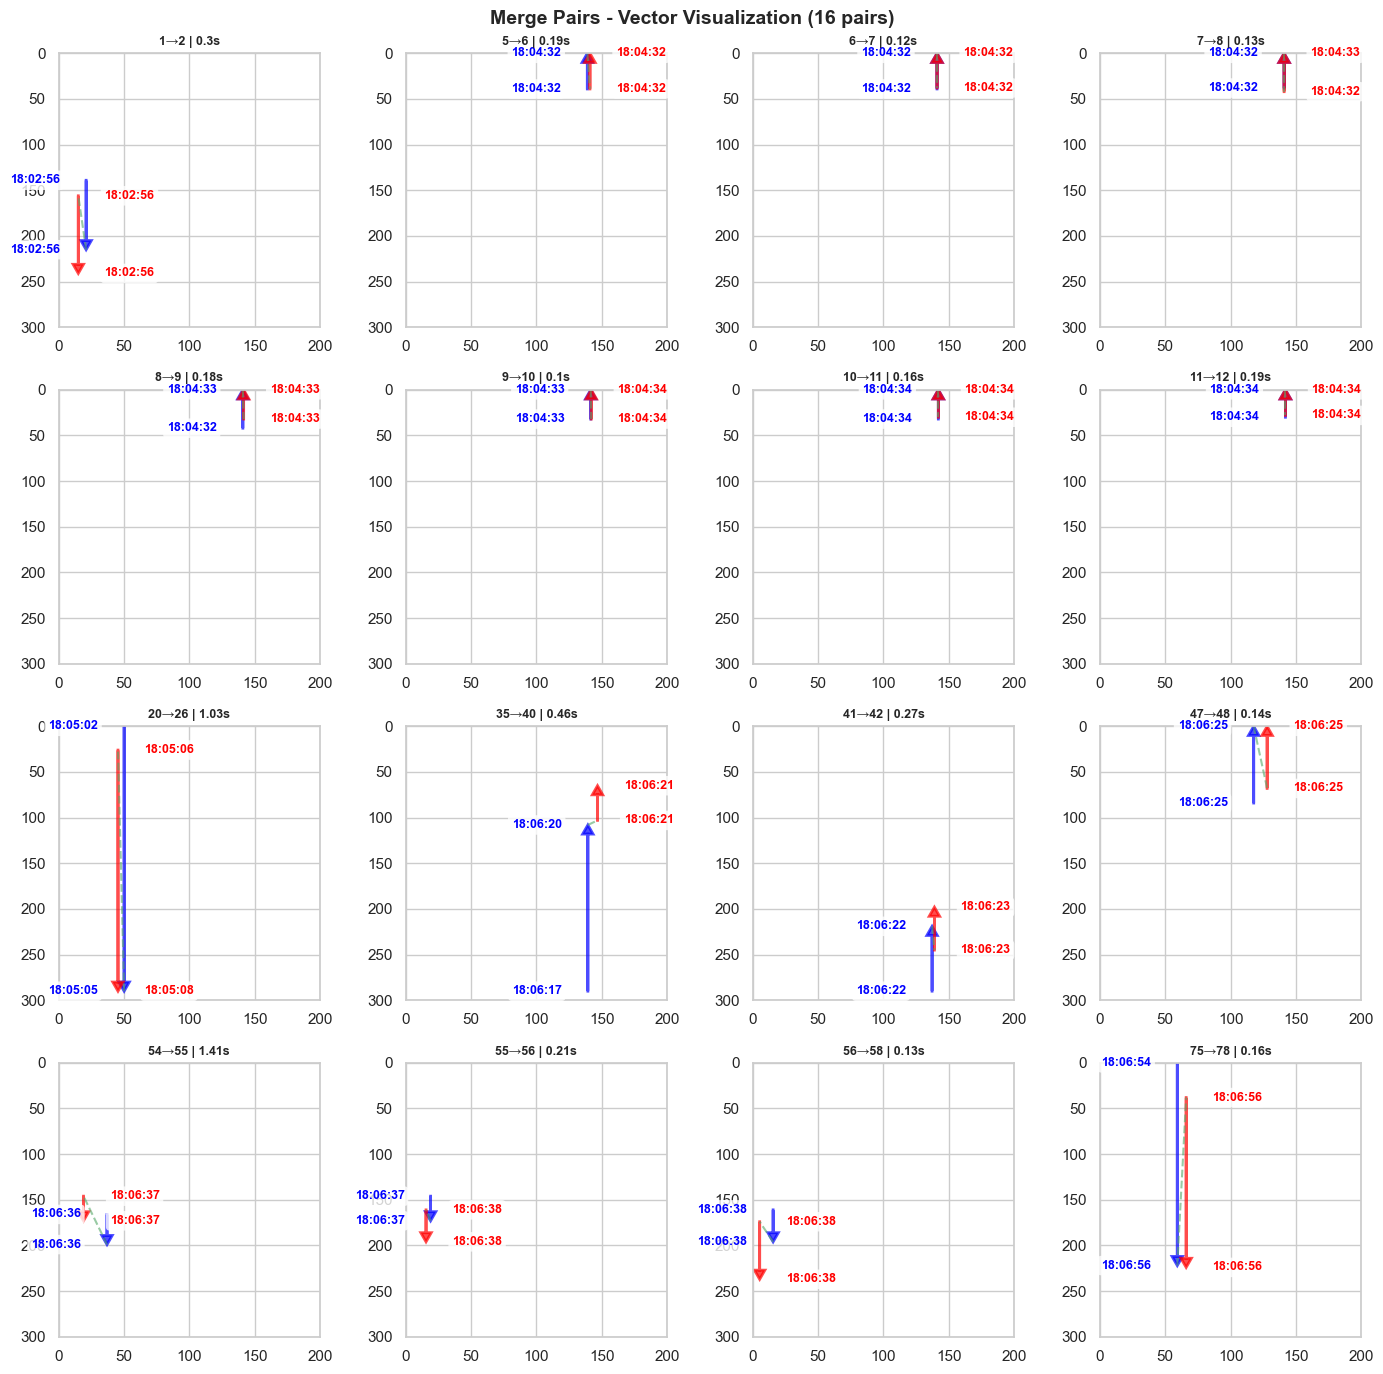

In [14]:
# Visualize
fig = visualize_merge_pairs_grid(merge_results, n_pairs=16, cols=4)
plt.show()


In [15]:
chains = build_merge_chains(merge_results)
print(f"Found {len(chains)} chains")
print(f"Longest chain has {max(len(c) for c in chains) if chains else 0} IDs")
print("\nFirst 10 chains (sorted by time):")
for i, chain in enumerate(chains[:10]):
    # Get start time for display
    first_id = chain[0]
    first_row = merge_results[merge_results['old_id'] == first_id].iloc[0] if len(merge_results[merge_results['old_id'] == first_id]) > 0 else None
    time_str = first_row['old_t_start'].strftime('%H:%M:%S') if first_row is not None else "??:??:??"
    print(f"{i+1}. [{time_str}] {' → '.join(map(str, chain))}")


Found 65243 chains
Longest chain has 147 IDs

First 10 chains (sorted by time):
1. [18:02:56] 1 → 2
2. [18:04:32] 5 → 6 → 7 → 8 → 9 → 10 → 11 → 12
3. [18:05:02] 20 → 26
4. [18:06:17] 35 → 40
5. [18:06:22] 41 → 42
6. [18:06:25] 47 → 48
7. [18:06:36] 54 → 55 → 56 → 58
8. [18:06:54] 75 → 78
9. [18:06:56] 76 → 79
10. [18:06:56] 77 → 80


In [16]:
long_chains = [chain for chain in chains if len(chain) > 2]
print(f"Chains with more than 2 IDs: {len(long_chains)}")
long_chains 

Chains with more than 2 IDs: 25578


[[5, 6, 7, 8, 9, 10, 11, 12],
 [54, 55, 56, 58],
 [108, 109, 110, 111],
 [118, 119, 120, 121, 122, 123],
 [129, 130, 131],
 [135, 138, 139, 140, 141, 143],
 [147, 149, 152],
 [153, 154, 155],
 [201, 202, 203],
 [214, 217, 221, 225],
 [241, 242, 243],
 [244, 246, 247],
 [249, 250, 251, 252],
 [253, 254, 255, 256, 257, 258, 259],
 [260, 261, 262, 263],
 [266, 268, 270],
 [274, 278, 281],
 [286, 289, 292, 295],
 [312, 315, 316, 317, 318],
 [351, 354, 357],
 [365, 368, 371],
 [414, 417, 420],
 [438, 440, 442],
 [615, 616, 617],
 [627, 628, 631, 633],
 [659, 662, 665],
 [705, 716, 720, 724],
 [733, 734, 735],
 [736, 737, 738],
 [780, 781, 782],
 [786, 787, 791],
 [838, 840, 846],
 [843, 844, 845, 848, 851],
 [849, 855, 859],
 [866, 867, 868, 869],
 [875, 878, 882],
 [876, 879, 883],
 [877, 880, 884],
 [896, 897, 899],
 [913, 914, 915],
 [918, 921, 923],
 [928, 929, 930, 934],
 [980, 981, 982],
 [1011, 1012, 1013, 1014],
 [1035, 1036, 1037],
 [1038, 1039, 1040, 1041],
 [1087, 1088, 1089],
 [

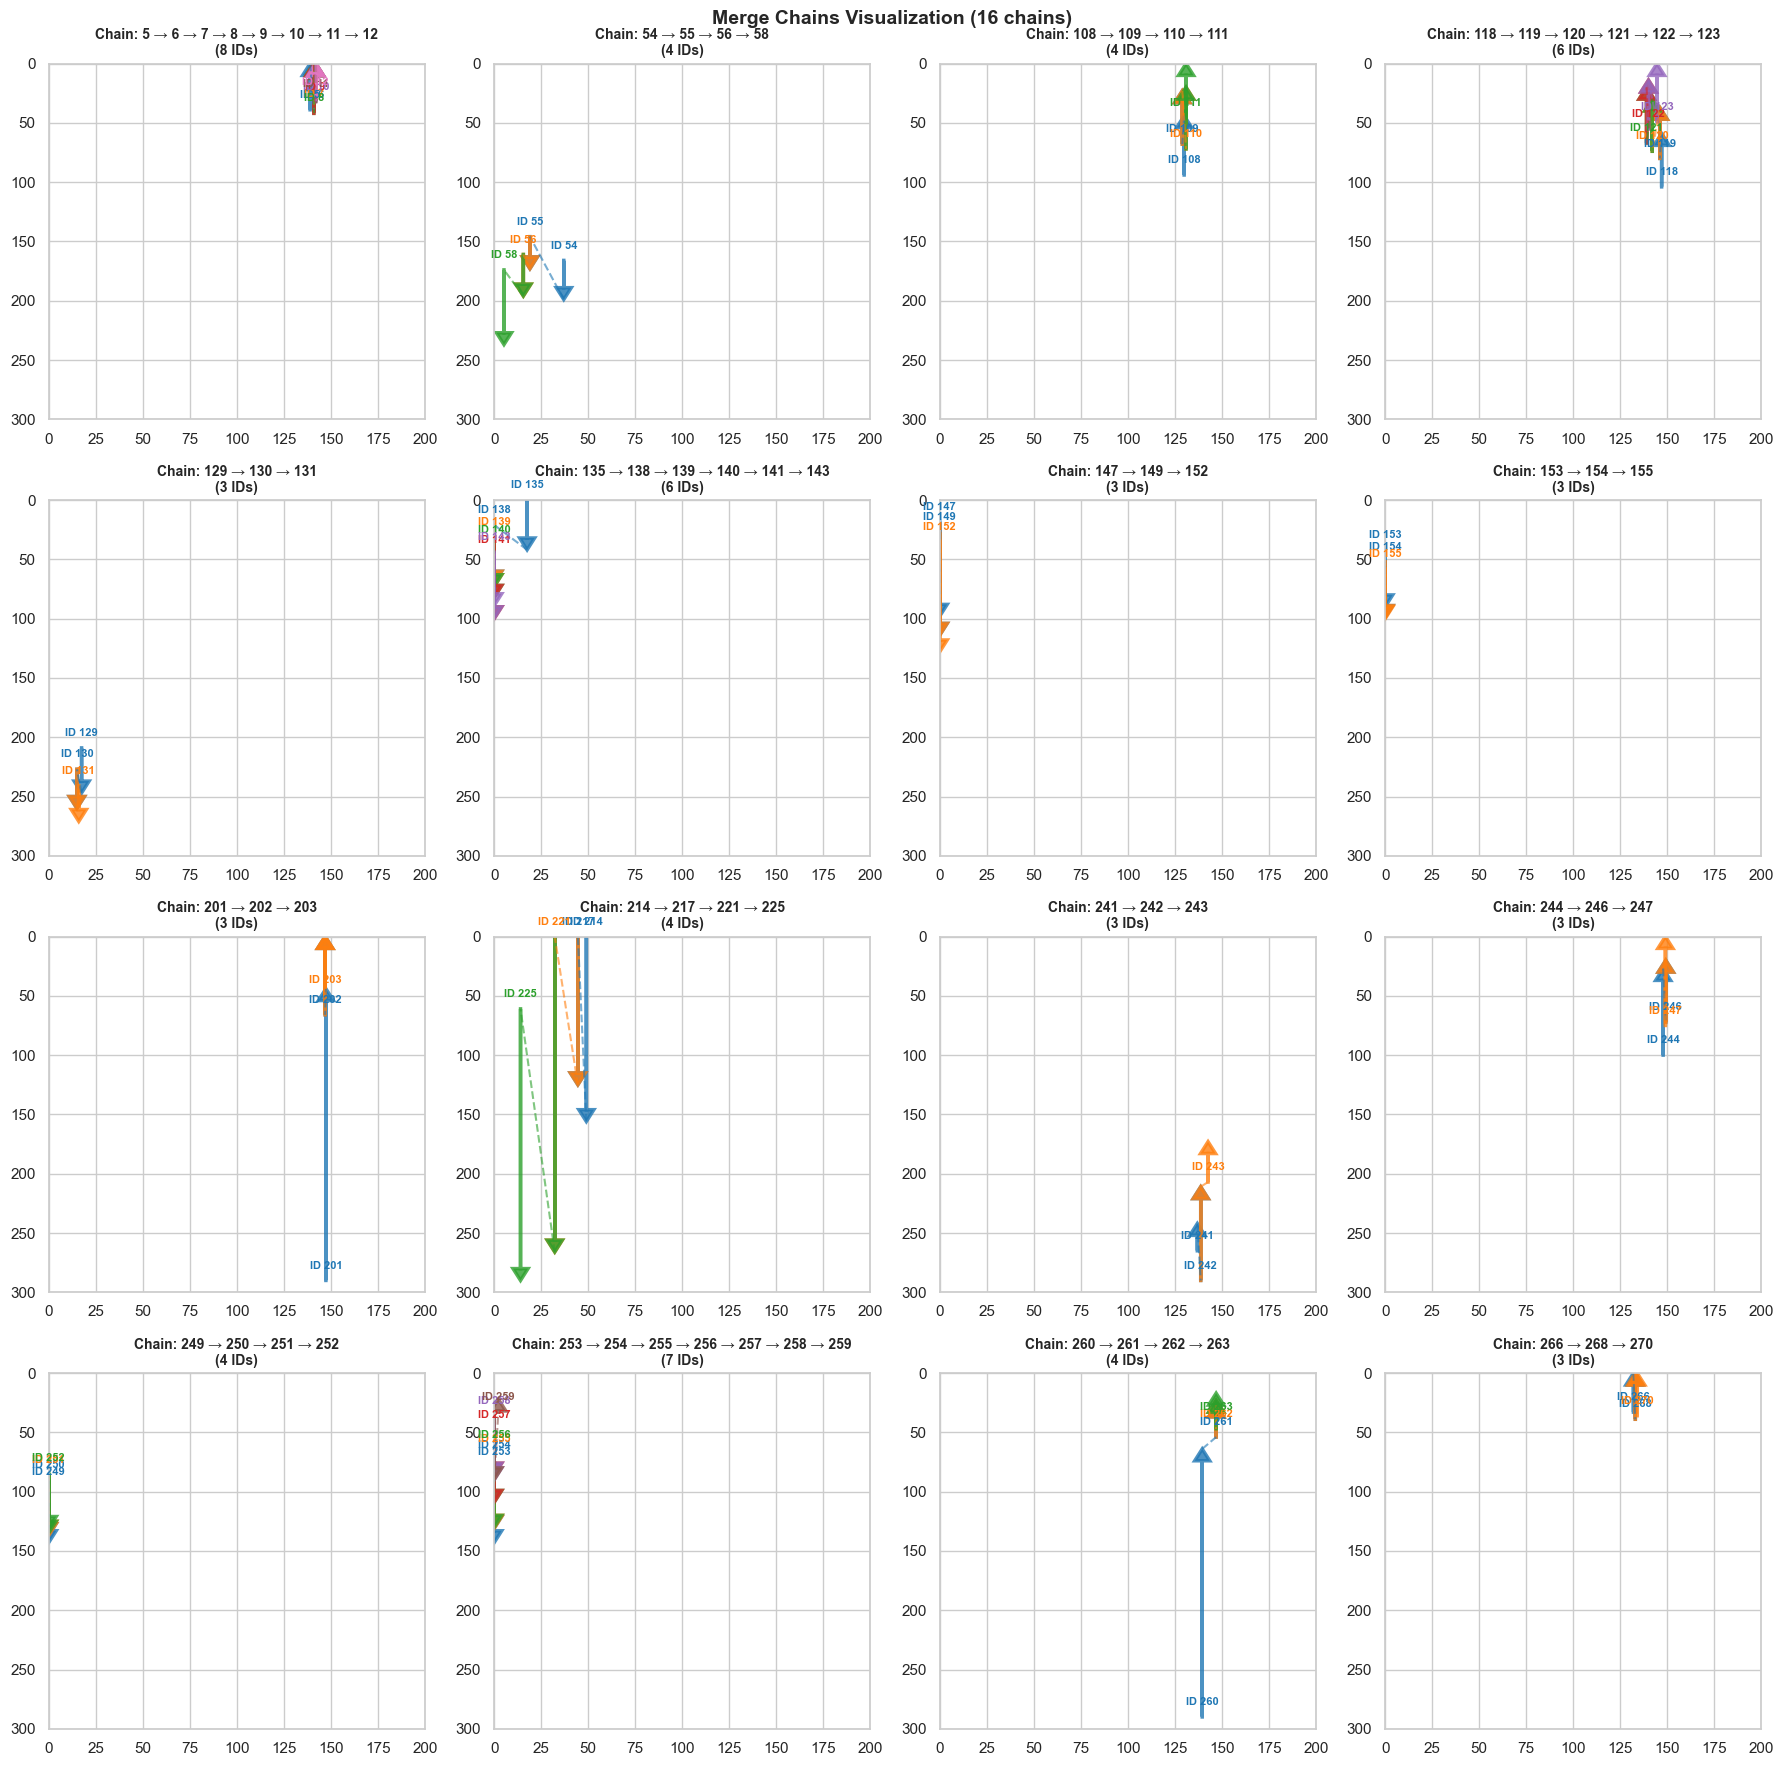

In [17]:
# Visualize chains
fig = visualize_merge_chains_grid(merge_results, long_chains, n_chains=16, cols=4)
plt.show()


In [21]:
# Applying the merge to the current session with consolidation
updated_summary = apply_merges_to_summary(final_summary, chains)

# Checking the result
print(f"Total IDs: {len(updated_summary)}")
print(f"IDs with unified_id: {updated_summary['unified_id'].notna().sum()}")
print(f"\nCategory distribution:")
print(updated_summary['category'].value_counts())
print(f"\nExample of Merged ID (consolidated):")
print(updated_summary[updated_summary['category'] == 'Merged'].head())

Total IDs: 352984
IDs with unified_id: 79220

Category distribution:
category
Ghost         258358
Perfect        29378
Merged         26183
Partial        23691
Noise          13358
Static          1427
Flickering       589
Name: count, dtype: int64

Example of Merged ID (consolidated):
    session_id vehicle_id  y_start  y_end     w_mean      w_std  w_start  \
1            2     [1, 2]      139    156  27.500000        NaN     26.0   
19           2   [20, 26]        0    270  76.563768  11.322228     77.0   
33           2   [35, 40]      264     65  56.563596  10.534834     56.0   
38           2   [41, 42]      268    198  39.318182   2.013590     46.0   
71           2   [75, 78]        0     62  63.517857   5.153296     65.0   

    w_end      h_mean      h_std  ...                    t_start  \
1    29.0   80.500000        NaN  ... 2025-11-29 18:02:56.049113   
19   67.0  146.492754  85.514101  ... 2025-11-29 18:05:02.199087   
33   56.0   82.497807  27.871572  ... 2025-11-29 1

In [22]:
# ids = {2799}

# filtered = updated_summary[
#     updated_summary['vehicle_id'].apply(lambda v: any(x in ids for x in v))
# ]
# print(filtered[['vehicle_id', 'y_start','y_end', 'x_mean', 'w_mean', 'frames_count', 'path_completeness', 'w_cv', 'h_start', 'h_end', 'category']])

In [23]:
# 'Ghost', 
# 'Static', 
# 'Perfect', 
# 'Flickering', 
# 'Partial'
# 'Noise'

In [24]:
# filtered_updated_summary[(filtered_updated_summary['path_completeness'] > 0.3)\
#                           & (filtered_updated_summary['w_cv'] < 0.45) & (filtered_updated_summary['h_cv'] > 0.45)]

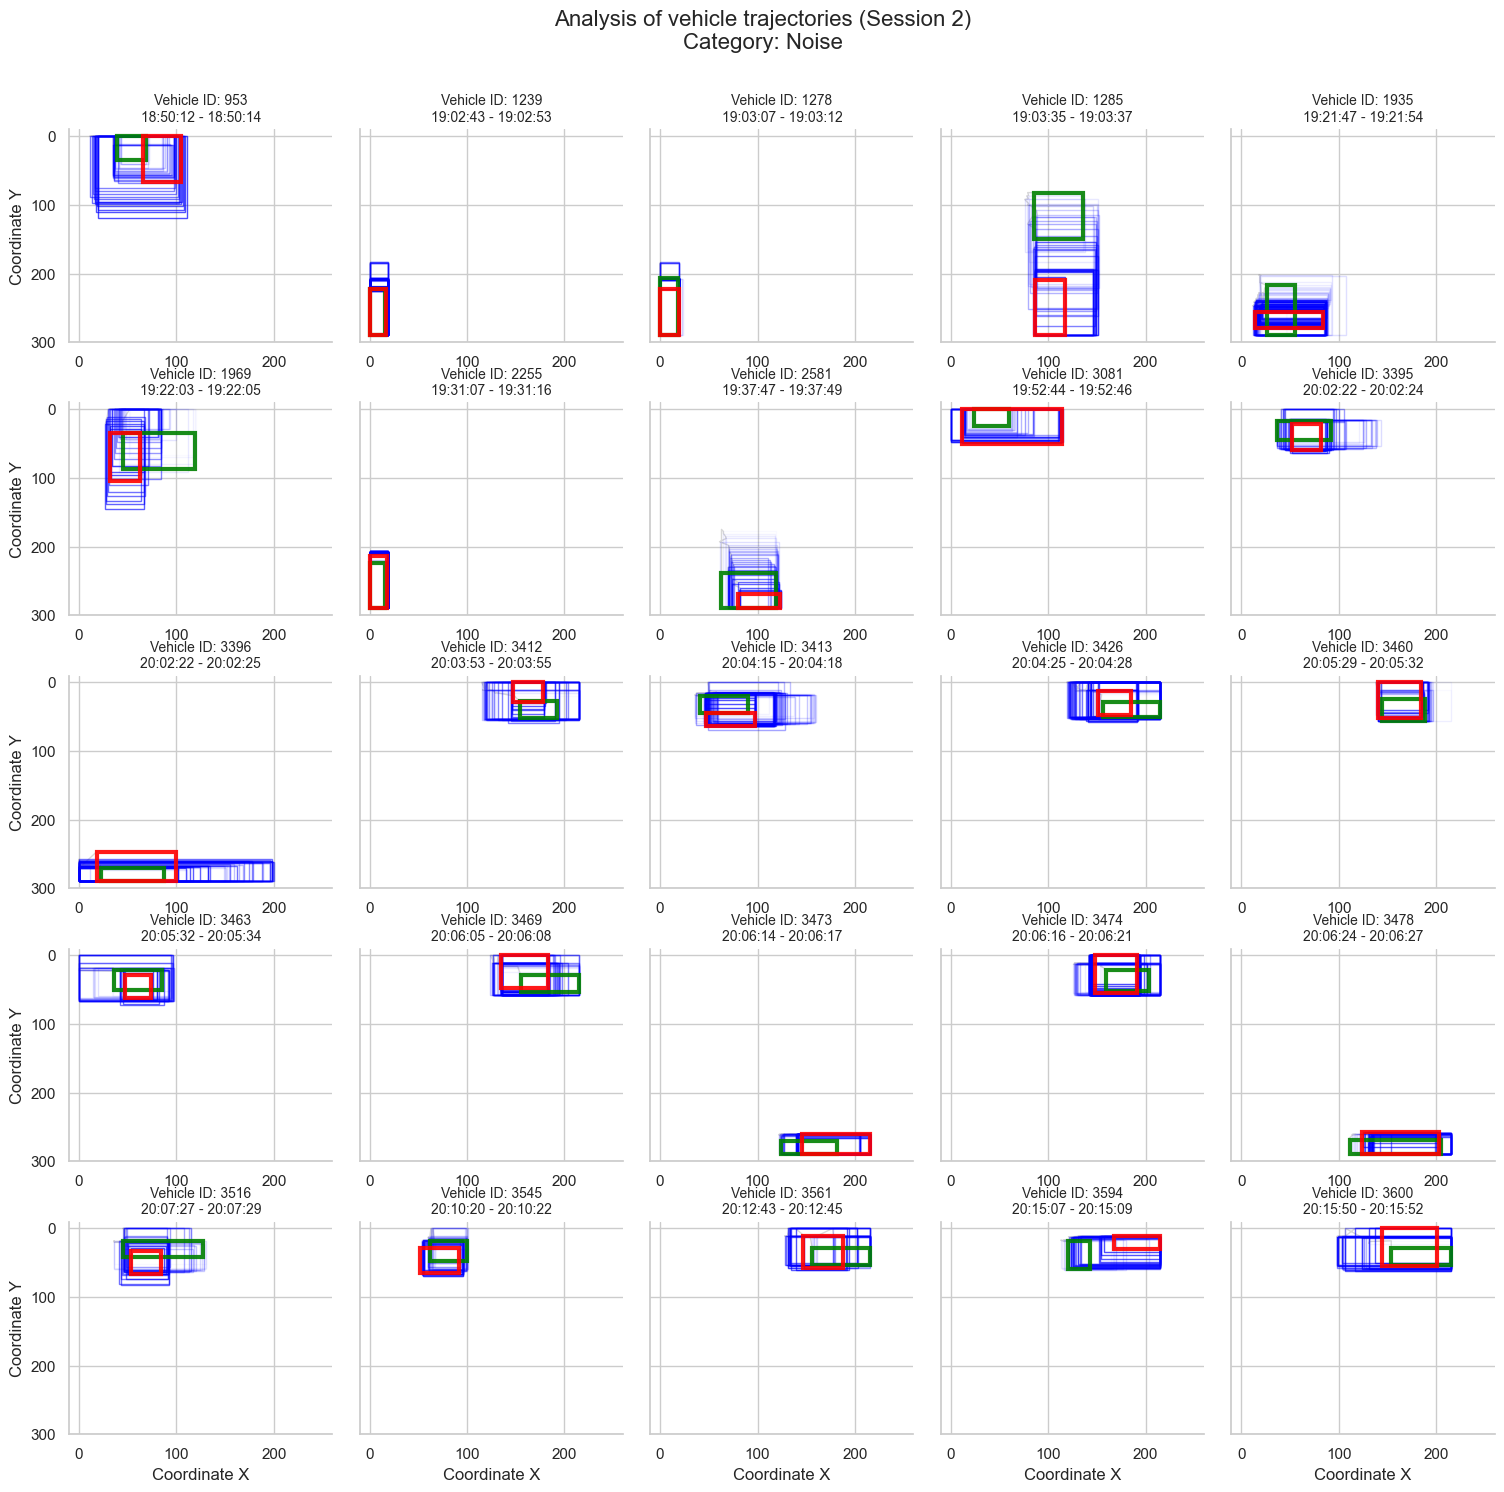

In [25]:
filter_category = 'Noise'
filtered_updated_summary = updated_summary[(updated_summary['category'] == filter_category)]
ids_to_plot = filtered_updated_summary['vehicle_id'].explode().tolist()
plot_data = session_df[session_df['vehicle_id'].isin(ids_to_plot)]
visualize_vehicle_trajectories(plot_data, session_id=session_id_to_analyze, max_vehicles=25, min_records=20, category=filter_category)

In [26]:
updated_summary[updated_summary['category'] == 'Merged']

session_id                vehicle_id  y_start  y_end      w_mean  \
1                2                    [1, 2]      139    156   27.500000   
19               2                  [20, 26]        0    270   76.563768   
33               2                  [35, 40]      264     65   56.563596   
38               2                  [41, 42]      268    198   39.318182   
71               2                  [75, 78]        0     62   63.517857   
...            ...                       ...      ...    ...         ...   
352888           2  [404054, 404055, 404057]        0    132  144.219697   
352911           2          [404080, 404081]        0      0  149.192308   
352913           2          [404083, 404085]       76      0   47.000000   
352932           2          [404103, 404107]       73      0   30.948718   
352951           2          [404123, 404126]      273      0  111.531944   

            w_std  w_start  w_end      h_mean      h_std  ...  \
1             NaN     26.0   29.0   80.500000        NaN  ...   
19      11.322228     77.0   67.0  146.492754  85.514101  ...   
33      10.534834     56.0   56.0   82.497807  27.871572  ...   
38       2.013590     46.0   37.0   44.772727   9.245146  ...   
71       5.153296     65.0   70.0  143.803571  40.744864  ...   
...           ...      ...    ...         ...        ...  ...   
352888  15.201408    138.0  196.0  260.840909  12.838405  ...   
352911  21.101991    157.0  104.0  167.894231  10.639230  ...   
352913   2.309401     48.0   44.0   37.625000  27.047797  ...   
352932   1.997299     33.0   29.0   63.192308  15.286071  ...   
352951  34.070151     80.0   48.0  134.446181  74.174468  ...   

                          t_start                      t_end      x_mean  \
1      2025-11-29 18:02:56.049113 2025-11-29 18:02:56.348841   18.000000   
19     2025-11-29 18:05:02.199087 2025-11-29 18:05:08.241317   47.765217   
33     2025-11-29 18:06:17.064019 2025-11-29 18:06:21.507959  143.059211   
38     2025-11-29 18:06:22.213265 2025-11-29 18:06:23.074102  138.090909   
71     2025-11-29 18:06:54.361938 2025-11-29 18:06:56.344102   62.589286   
...                           ...                        ...         ...   
352888 2025-12-18 10:54:43.540070 2025-12-18 10:54:44.817568    0.000000   
352911 2025-12-18 10:55:54.375926 2025-12-18 10:55:55.146567   54.682692   
352913 2025-12-18 10:56:01.622733 2025-12-18 10:56:01.808476  137.750000   
352932 2025-12-18 10:56:55.289286 2025-12-18 10:56:57.650637  144.051282   
352951 2025-12-18 10:59:44.068165 2025-12-18 10:59:48.759126   96.970660   

            x_std path_completeness      w_cv      h_cv  movement_efficiency  \
1             NaN          0.351724       NaN       NaN             0.175862   
19       5.109846          1.000000  0.147880  0.583743             0.013158   
33       9.175613          0.775862  0.186248  0.337846             0.012719   
38       0.981650          0.317241  0.051213  0.206491             0.026437   
71       5.246468          0.772414  0.081131  0.283337             0.025747   
...           ...               ...       ...       ...                  ...   
352888   0.000000          0.544828  0.105405  0.049219             0.019458   
352911  21.175165          0.662069  0.141442  0.063369             0.031527   
352913   1.732051          0.351724  0.049136  0.718878             0.070345   
352932   1.353259          0.520690  0.064536  0.241898             0.013017   
352951  28.606928          1.000000  0.305474  0.551704             0.009174   

        category  unified_id  
1         Merged           1  
19        Merged           8  
33        Merged          12  
38        Merged          13  
71        Merged          20  
...          ...         ...  
352888    Merged      118233  
352911    Merged      118245  
352913    Merged      118247  
352932    Merged      118256  
352951    Merged      118267  

[26183 rows x 23 columns]

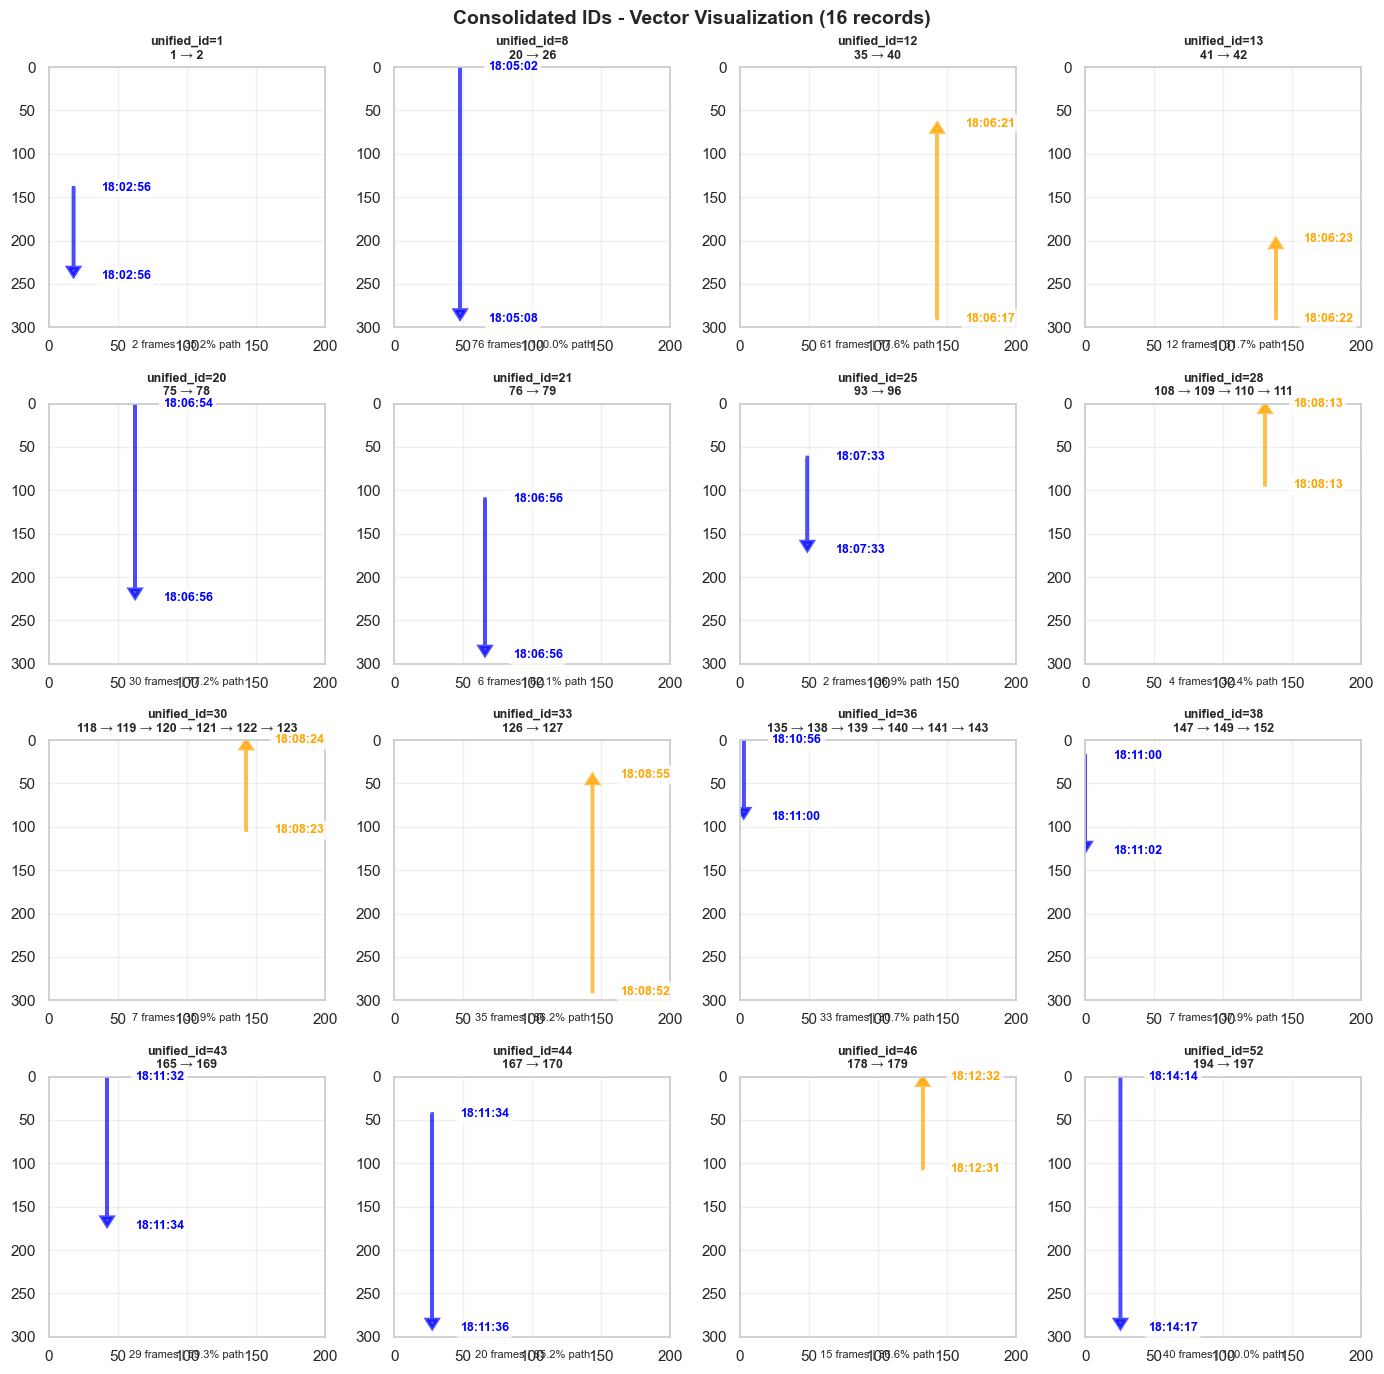

In [27]:
# Visualisation of consolidated IDs as vectors (pure arrows)
df_to_plot = updated_summary[updated_summary['category'] == 'Merged']
fig = visualize_consolidated_merges_grid(df_to_plot, n_merges=16, cols=4)
plt.show()

In [28]:
processed_summary = process_all_sessions(
    df,
)

Processing 16 sessions...

📍 Session 1/16 (session_id=0)
--------------------------------------------------------------------------------
  Step 1: Categorizing IDs...
  Category distribution:
    • Flickering     :    1 IDs
    • Ghost          : 2396 IDs
    • Noise          :   17 IDs
    • Partial        :  190 IDs
    • Perfect        :   43 IDs

  Step 2: Finding merge pairs...
  Found pairs for merging: 1252

  Step 3: Building merge chains and consolidating...
  Built 453 chains
    • Longest chain: 41 IDs
    • Average chain length: 3.8 IDs
  ✓ Consolidated into 187 merged records
  ✓ Total records with unified_id: 369

📍 Session 2/16 (session_id=1)
--------------------------------------------------------------------------------
  Step 1: Categorizing IDs...
  Category distribution:
    • Flickering     :    1 IDs
    • Ghost          :  360 IDs
    • Noise          :    1 IDs
    • Partial        :   52 IDs
    • Perfect        :  161 IDs

  Step 2: Finding merge pairs...
  F

# Summary Statistics & Visualizations

Comprehensive analysis of processed traffic data across all sessions

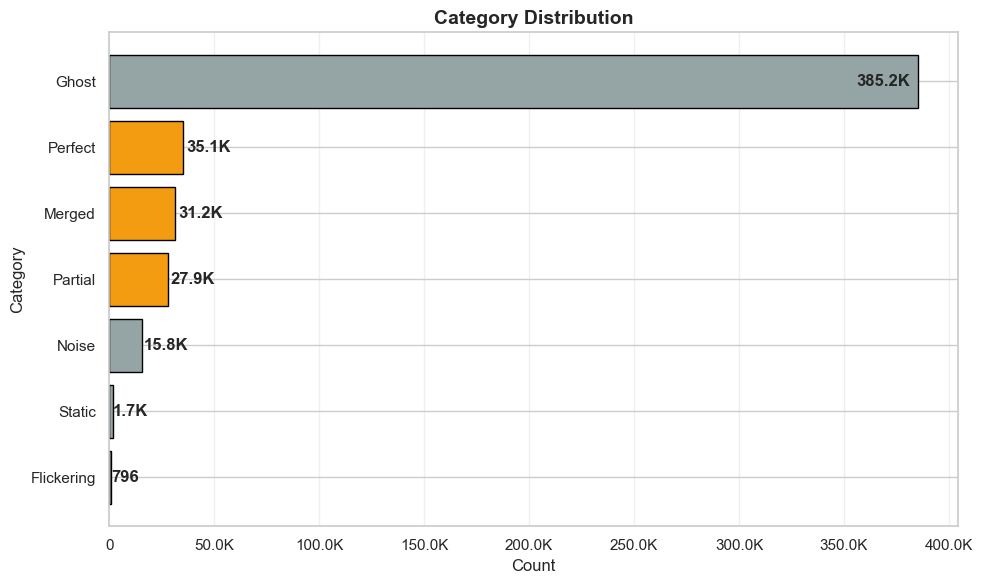

In [58]:
# 1. Category Distribution
plt.figure(figsize=(10, 6))

# Horizontal bar chart - sorted from largest to smallest (top to bottom)
category_counts = processed_summary['category'].value_counts().sort_values(ascending=True)

# Define colors: Perfect, Merged, Partial get the same orange color, others are gray
color_map = {
    'Perfect': '#f39c12',    # Orange
    'Merged': '#f39c12',     # Orange
    'Partial': '#f39c12',    # Orange
}
colors = [color_map.get(cat, '#95a5a6') for cat in category_counts.index]

plt.barh(range(len(category_counts)), category_counts.values, color=colors, edgecolor='black')
plt.yticks(range(len(category_counts)), category_counts.index)
plt.title('Category Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Count')
plt.ylabel('Category')
plt.grid(axis='x', alpha=0.3)

# Format numbers as K (thousands)
def format_number(x):
    if x >= 1000:
        return f'{x/1000:.1f}K'
    return f'{int(x)}'

# Format x-axis labels
from matplotlib.ticker import FuncFormatter
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, p: format_number(x)))

# Add counts on bars
max_value = category_counts.max()
for i, v in enumerate(category_counts.values):
    # If value is much larger than others (like Ghost), place text inside the bar
    if v > max_value * 0.8:
        plt.text(v * 0.99, i, format_number(v), 
                va='center', ha='right', fontweight='bold')
    else:
        plt.text(v * 1.05, i, format_number(v), 
                va='center', fontweight='bold')

plt.tight_layout()
plt.show()


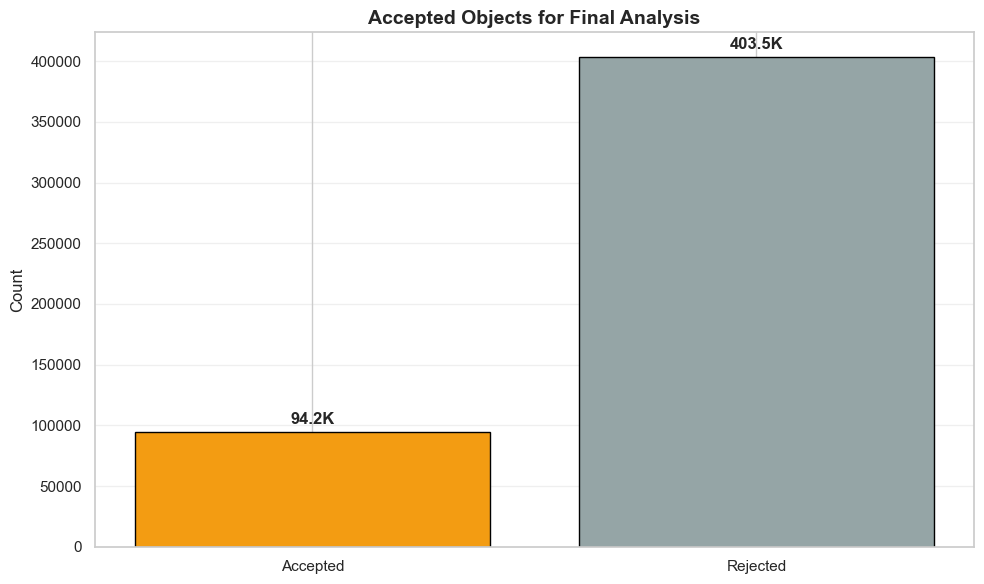

In [57]:
# 2. Unified ID Statistics
plt.figure(figsize=(10, 6))

# Unified ID coverage
unified_stats = pd.DataFrame({
    'Type': ['Accepted', 'Rejected'],
    'Count': [processed_summary['unified_id'].notna().sum(), 
              processed_summary['unified_id'].isna().sum()]
})
colors = ['#f39c12', '#95a5a6']
plt.bar(unified_stats['Type'], unified_stats['Count'], color=colors, edgecolor='black')
plt.title('Accepted Objects for Final Analysis', fontsize=14, fontweight='bold')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)

# Format numbers as K (thousands)
def format_number(x):
    if x >= 1000:
        return f'{x/1000:.1f}K'
    return f'{int(x)}'

# Add counts on bars
for i, v in enumerate(unified_stats['Count']):
    plt.text(i, v + max(unified_stats['Count'])*0.01, format_number(v), 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()
